# Heart Disease Classification

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
from scipy.stats import entropy

# load the dataset
from collections import Counter
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

# Functions

In [2]:
def run_all_models(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
    models = {
        "LogisticRegression": LogisticRegression(),
        "SVC": SVC(),
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "KNeighborsClassifier": KNeighborsClassifier(),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
        "GaussianNB": GaussianNB(),
        "LDA":LinearDiscriminantAnalysis(),
        "GPC":GaussianProcessClassifier()
    }

    # Create an empty DataFrame to store model performance
    model_performance = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        predictions = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, predictions)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy
        })

    # For the Sequential model
    sequential_model = Sequential()
    sequential_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    sequential_model.add(Dense(32, activation='relu'))
    sequential_model.add(Dense(1, activation='sigmoid'))
    sequential_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    sequential_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=10, verbose=0)
    loss, accuracy = sequential_model.evaluate(X_test_scaled, y_test_encoded)
    model_performance.append({
        "Model": "Sequential",
        "Accuracy": accuracy
    })

    # Convert the model_performance to a DataFrame
    return pd.DataFrame(model_performance)

def automate_pca(pca_components, X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
  pca = PCA(n_components=pca_components)
  X_train_pca = pca.fit_transform(X_train_scaled)
  X_test_pca = pca.transform(X_test_scaled)
  
  models = run_all_models(X_train_pca, X_test_pca, y_train_encoded, y_test_encoded)
  print(models)
  
def labels_to_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return probabilities

def calculate_entropy(df:pd.DataFrame)-> pd.DataFrame:
  """_summary_

  Args:
      df (pd.DataFrame): _description_

  Returns:
      pd.DataFrame: _description_
  """

  column_entropy_info = {}
  for col in df.columns:
    probabilities = labels_to_probabilities(df[col])
    entropy_value = entropy(probabilities, base=2)
    column_entropy_info[col] = {
          'entropy': entropy_value
      }

  return pd.DataFrame(column_entropy_info)

# EDA Analysis

In [20]:
df = pd.read_csv("heart.csv")
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [4]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [8]:
entropy_df = calculate_entropy(df)
entropy_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
entropy,5.225599,0.741941,1.631436,4.698175,6.750721,0.783403,1.368659,6.344942,0.973321,3.702449,1.288266,0.991764


In [9]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [32]:
target = df.values[:,-1]

counter = Counter(target)

for k,v in counter.items():
  per = v/len(target) * 100
  print("Class=%d, Count=%d, Percentage=%.3f%%" % (k, v, per))

Class=0, Count=410, Percentage=44.662%
Class=1, Count=508, Percentage=55.338%


### Great news, we have a fairly balanced dataset to work with

# Data Preperation

In [22]:

df["Sex"] = df["Sex"].apply(lambda x: 1 if x =="M" else 0)
df["ExerciseAngina"] = df["ExerciseAngina"].apply(lambda x: 1 if x == "Y" else 0)
df["ST_Slope"] = df["ST_Slope"].apply(lambda x: 0 if x =="Flat" else 1 if x == "Up" else 2)
df["RestingECG"] = df["RestingECG"].apply(lambda x: 0 if x =="Normal" else 1 if x == "LVH" else 2)
df["ChestPainType"] = df["ChestPainType"].apply(lambda x: 0 if x =="ASY" else 1 if x == "NAP" else 2 if x == "ATA" else 3)


In [26]:
df.dtypes

Age                 int64
Sex                 int64
ChestPainType       int64
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG          int64
MaxHR               int64
ExerciseAngina      int64
Oldpeak           float64
ST_Slope            int64
HeartDisease        int64
dtype: object

# Visuals

<Axes: >

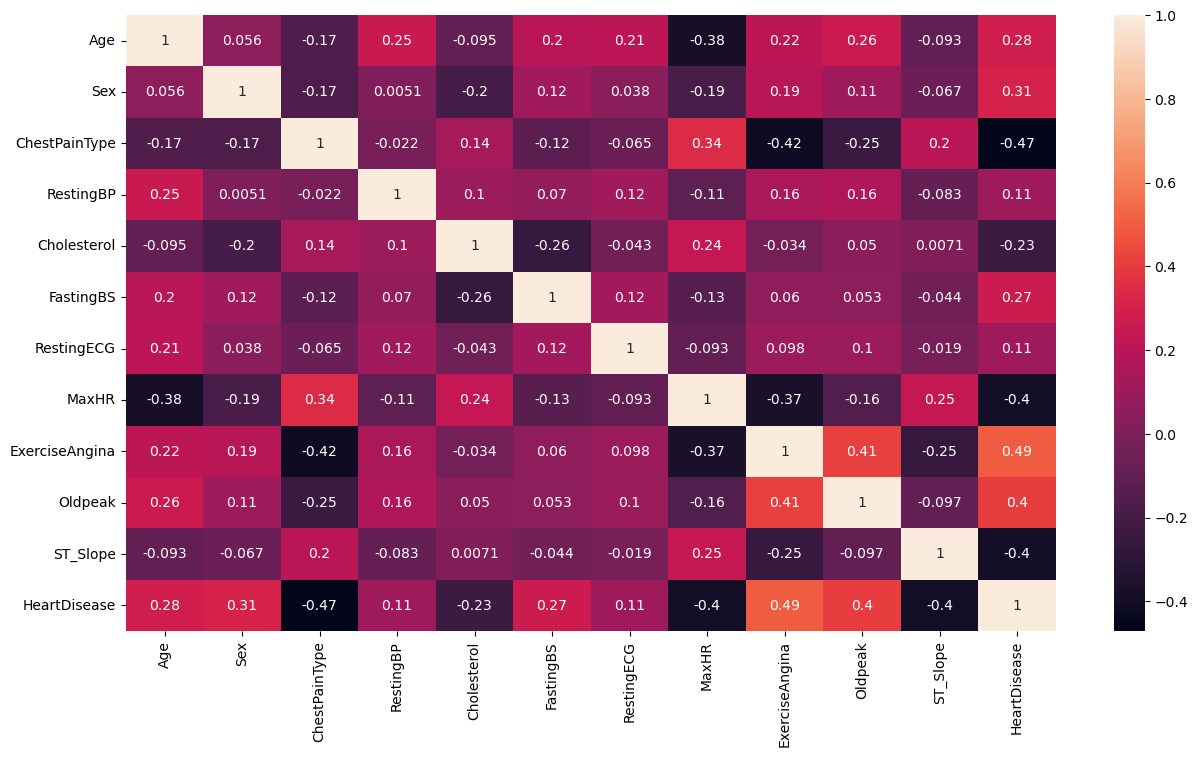

In [27]:
relations = df.corr()
plt.figure(figsize=(15,8))
sns.heatmap(data=relations, annot=True)

<Axes: xlabel='Sex'>

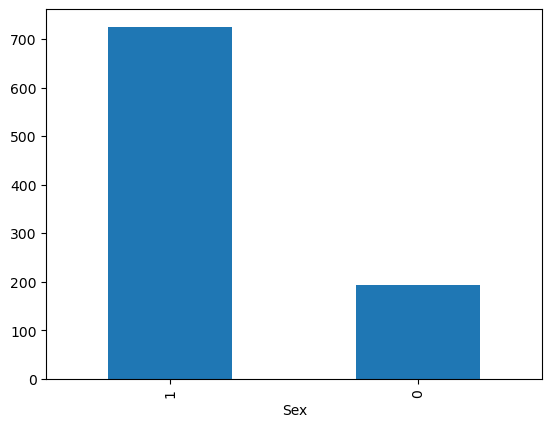

In [23]:
df["Sex"].value_counts().plot.bar()

<Axes: xlabel='ST_Slope'>

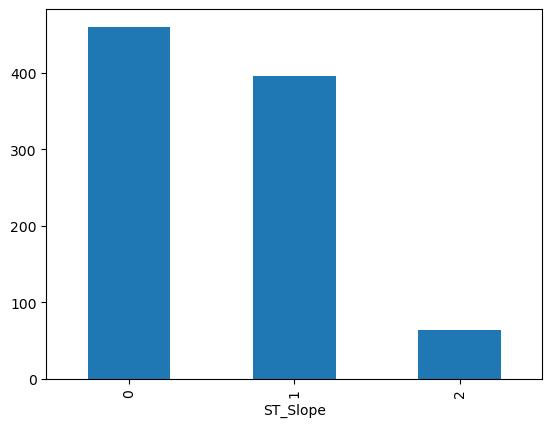

In [17]:
df["ST_Slope"].value_counts().plot.bar()

<Axes: xlabel='ChestPainType'>

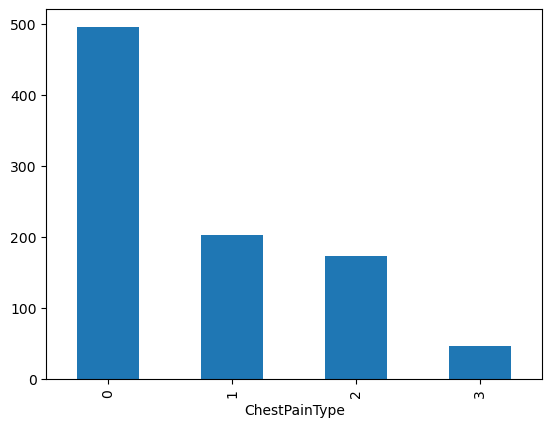

In [18]:
df["ChestPainType"].value_counts().plot.bar()

<Axes: xlabel='RestingECG'>

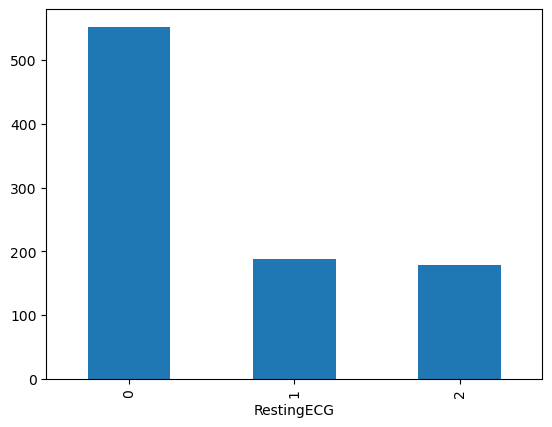

In [24]:
df["RestingECG"].value_counts().plot.bar()

/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/18781

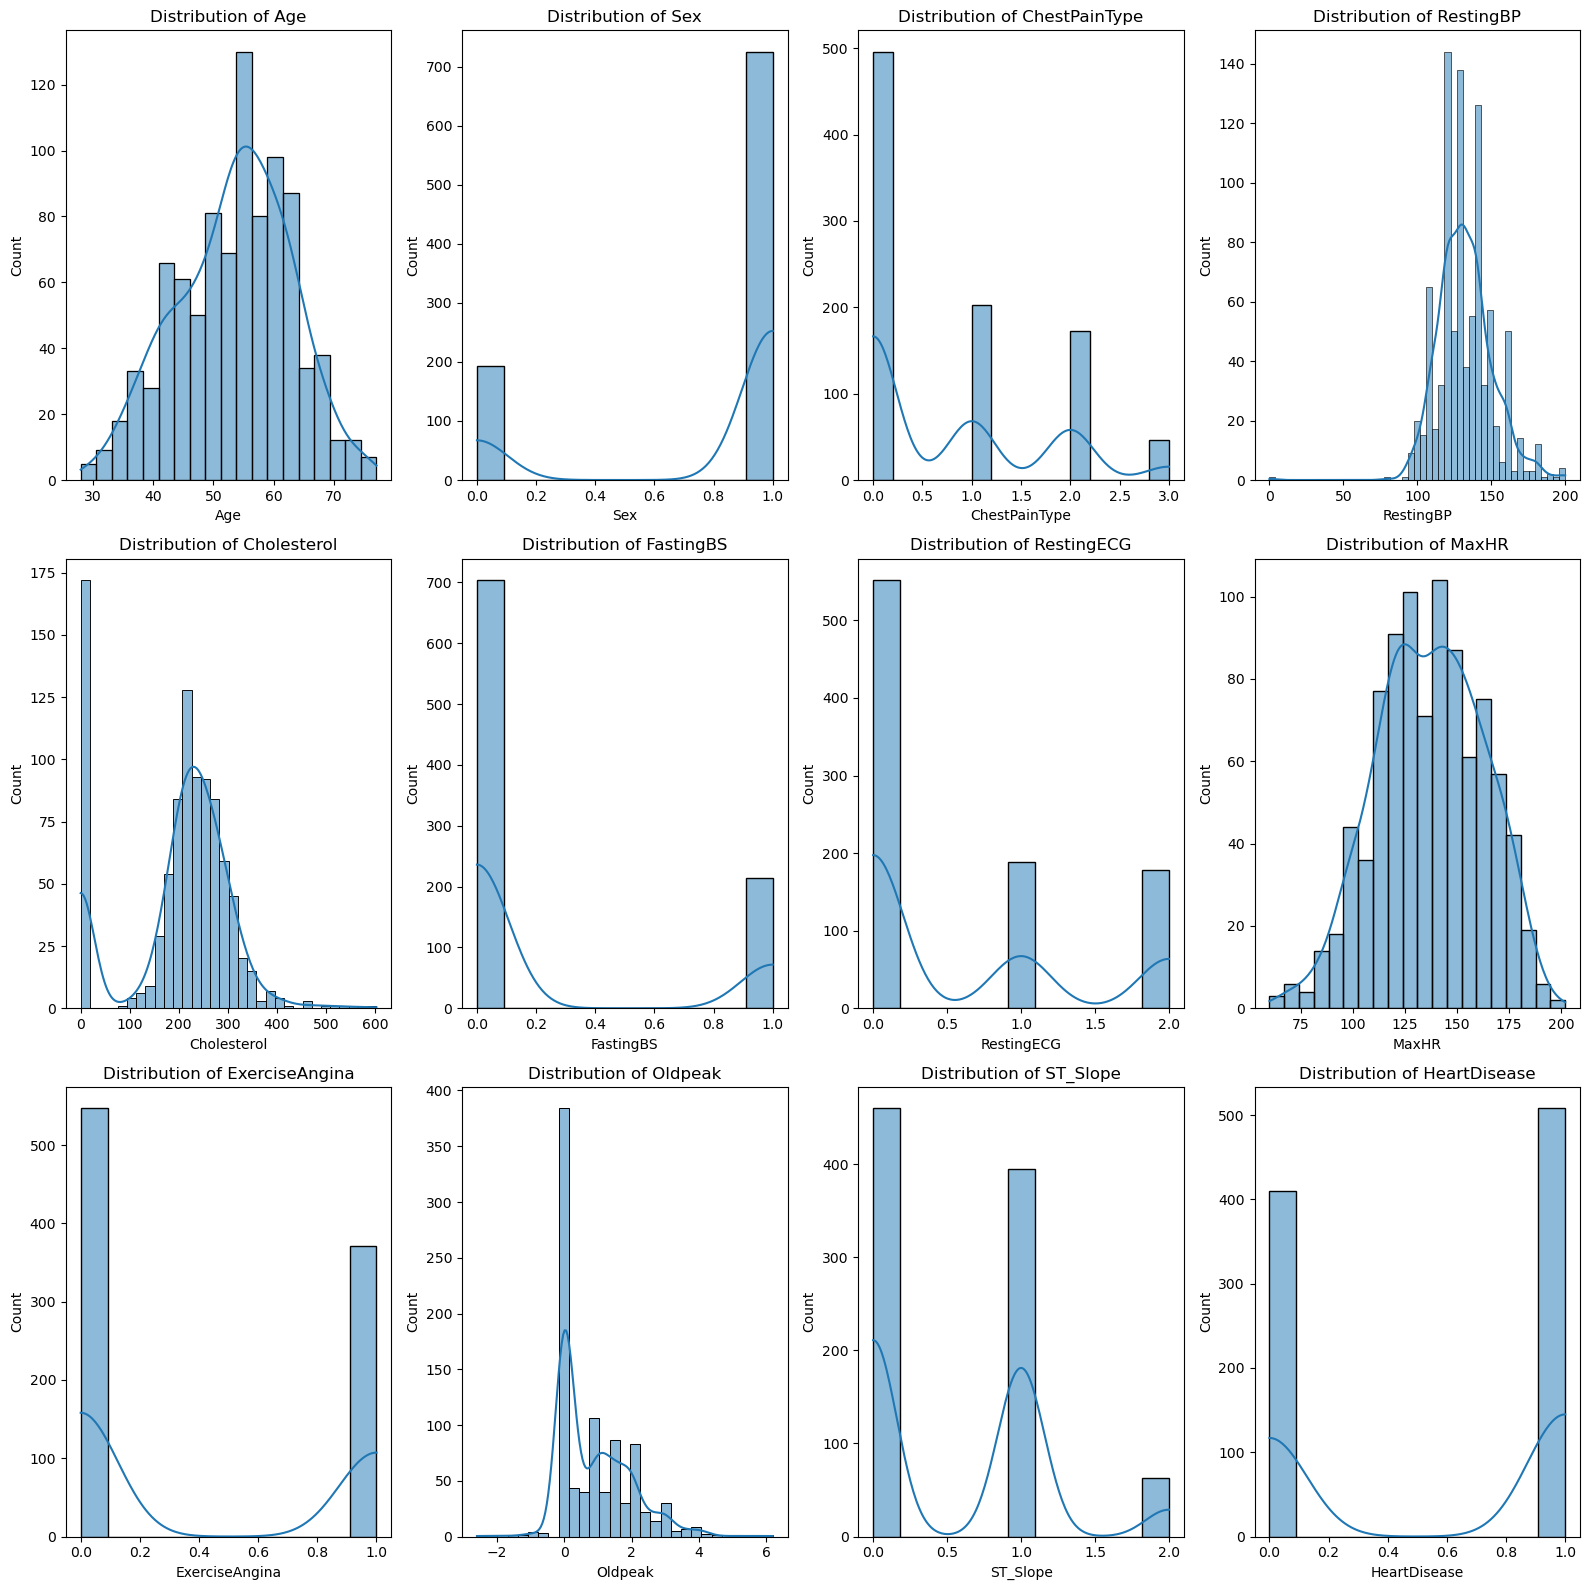

In [28]:
df_width= len(df.columns)
rows = (df_width +3)//4
plt.figure(figsize=(16,16))

for idx, col in enumerate(df.columns):
  plt.subplot(rows, 4, idx+1)
  sns.histplot(df[col], kde=True)
  plt.title(f"Distribution of {col}")
  plt.tight_layout()
  plt.plot()

## I am not a doctor but is it possible to have 0 cholesterol? (Apparently low cholesterol is a sign for numerous health problems so we cannot remove it from the data set)

/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_30333/33908

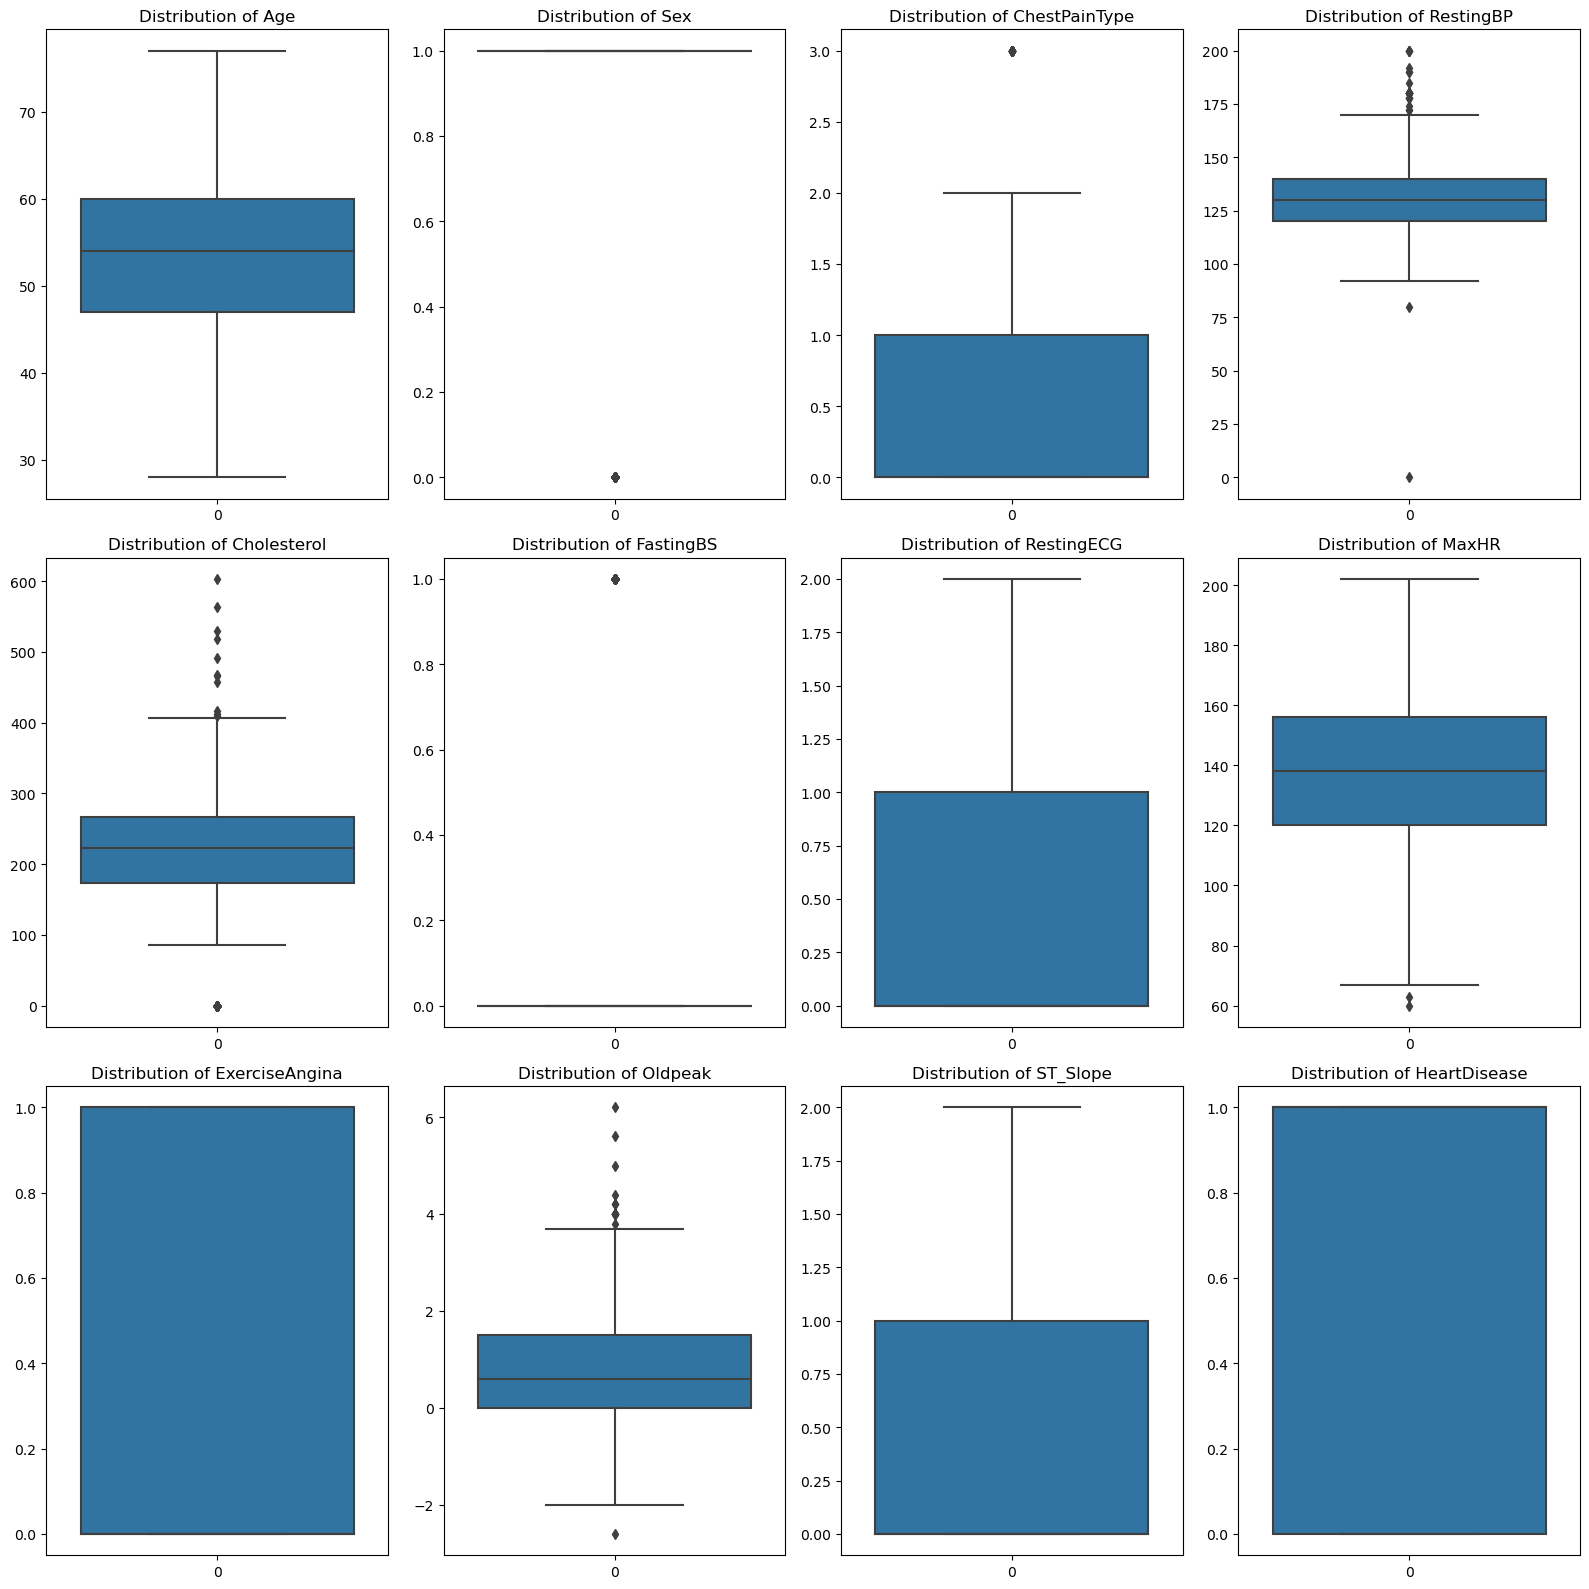

In [29]:
df_width= len(df.columns)
rows = (df_width +3)//4
plt.figure(figsize=(16,16))

for idx, col in enumerate(df.columns):
  plt.subplot(rows, 4, idx+1)
  sns.boxplot(df[col])
  plt.title(f"Distribution of {col}")
  plt.tight_layout()
  plt.plot()

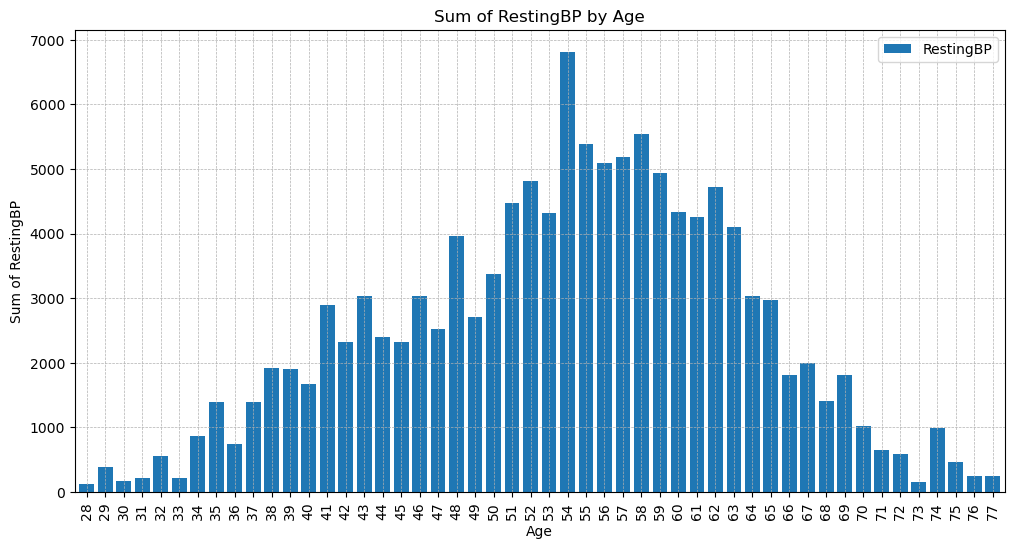

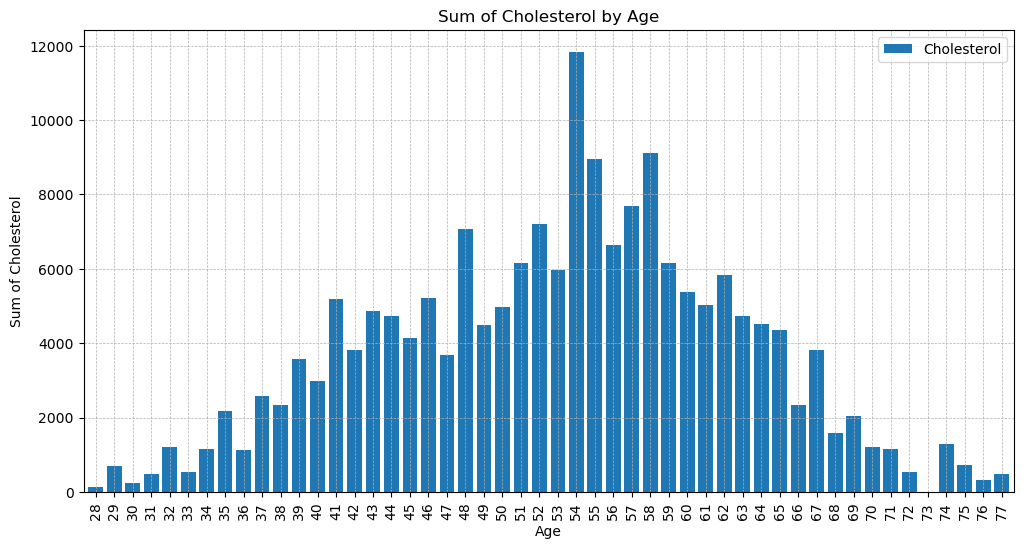

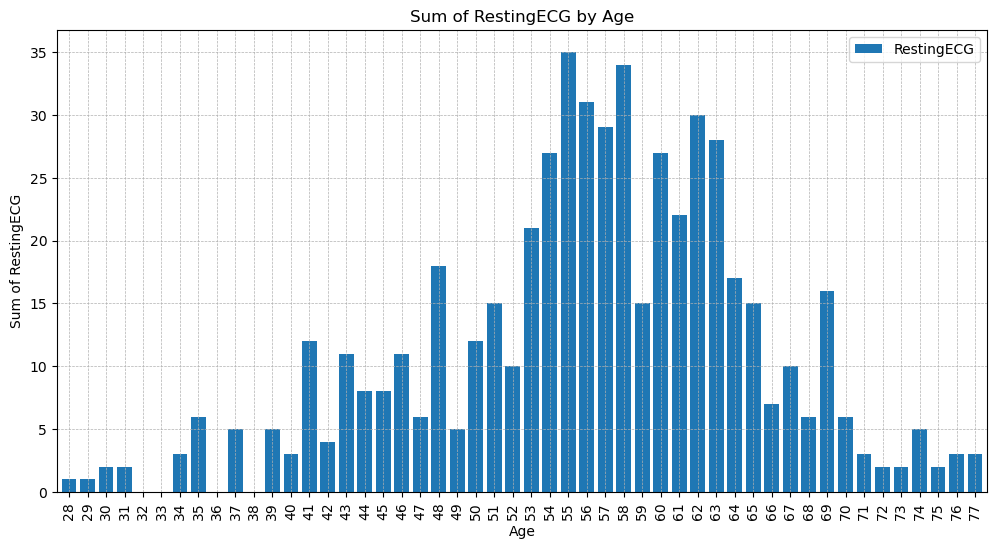

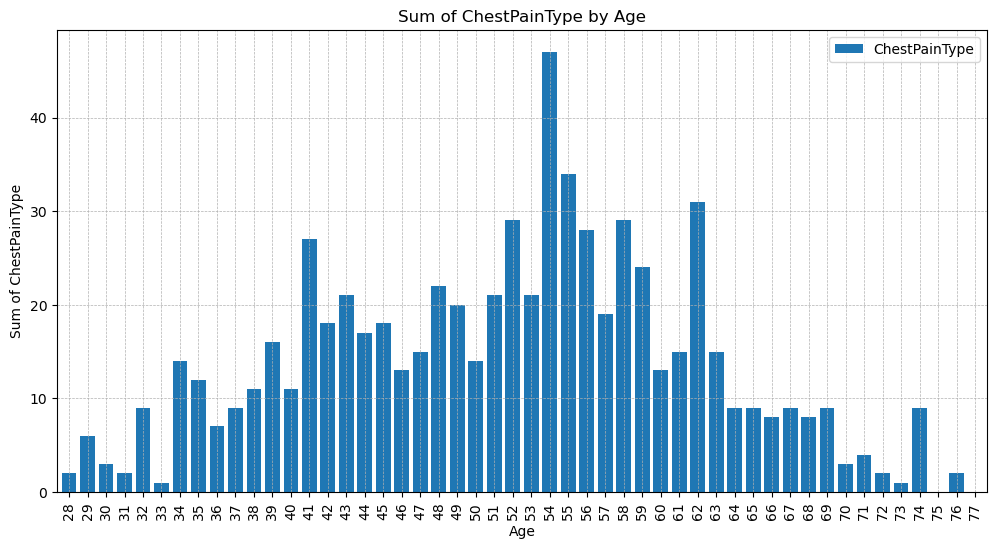

In [45]:

# Set a larger figure size and higher resolution
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

interested_columns = ["RestingBP", "Cholesterol", "RestingECG", "ChestPainType"]

for col in interested_columns:
    df_grouped = df.groupby("Age")[col].sum().reset_index()
    
    # Create the plot
    df_grouped.plot(kind="bar", x="Age", y=col, width=0.8) # Adjust bar width as needed
    
    # Set labels and title
    plt.xlabel("Age")
    plt.ylabel(f"Sum of {col}")
    plt.title(f"Sum of {col} by Age")
    
    # Add gridlines
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Show the plot
    plt.show()

# Model Evaluation

In [54]:
from sklearn.metrics import fbeta_score


def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  
  metric = make_scorer(f2_measure)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

last_ix = len(df.columns)-1
X, y = df.drop(df.columns[last_ix], axis=1), df[df.columns[last_ix]]
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))
# define the reference model
model = DummyClassifier(strategy='stratified')
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean F2: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

(918, 11) (918,) Counter({1: 508, 0: 410})


Mean F2: 0.546 (0.057)


## Baseline Model Performance tell us we need an F2 score of atleast 0.55%. One thing to note here, is how we decide to measure how grave a type two error is. In this case, that would be telling a patient they don't have heart disease when in fact they do have heart disease. This is the scope through which I am guiding my analysis. Given that Heart Disease is one of the leasing causes of death for adults in America


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)
models = run_all_models(X_train_scaled, X_test_scaled, y_train, y_test)
models.sort_values(by="Accuracy", ascending=False)

2024-04-01 18:26:43.079729: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


6/6 [==============================] - 0s 569us/step - loss: 0.4142 - accuracy: 0.8424


,Model,Accuracy
3,RandomForestClassifier,0.869565
1,SVC,0.864130
4,KNeighborsClassifier,0.864130
5,GradientBoostingClassifier,0.864130
0,LogisticRegression,0.858696
8,GPC,0.858696
7,LDA,0.847826
9,Sequential,0.842391
6,GaussianNB,0.836957
2,DecisionTreeClassifier,0.815217


# Advanced Modeling

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer

def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  
  metric = make_scorer(f2_measure)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

# define models to test
def get_models():
  models, names = list(), list()
  # LDA
  models.append(LinearDiscriminantAnalysis()) 
  names.append('LDA')
  # RFC
  models.append(RandomForestClassifier())
  names.append('RFC')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # KNN
  models.append(KNeighborsClassifier())
  names.append('KNN')
  # SVC
  models.append(SVC())
  names.append('SVC')
  # LR
  models.append(LogisticRegression())
  names.append('LR')
  #GPC
  models.append(GaussianProcessClassifier())
  names.append('GPC')
  #GNB
  models.append(GaussianNB())
  names.append('GNB')
  #DTC
  models.append(DecisionTreeClassifier())
  names.append('DTC')
  
  return models, names

last_ix = len(df.columns)-1
X, y = df.drop(df.columns[last_ix], axis=1), df[df.columns[last_ix]]
models, names = get_models()
# evaluate each model
for i in range(len(models)):
  # Wrap the model in a pipeline with StandardScaler
  pipeline = Pipeline(steps=[('scaler', StandardScaler()), ("power_tranformer",PowerTransformer()), ('model', models[i])])
  # Evaluate the model
  scores = evaluate_model(X, y, pipeline)  # Replace X, y with your data
  # summarize and store
  print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>LDA 0.864 (0.042)
>RFC 0.901 (0.036)
>GBC 0.892 (0.039)
>KNN 0.878 (0.036)
>SVC 0.906 (0.036)
>LR 0.869 (0.042)
>GPC 0.866 (0.040)
>GNB 0.877 (0.033)
>DTC 0.806 (0.053)


## After testing on multiple subsets of data, the models with the highest mean and lowest STD ratio will be picked to continue our modeling process

## Top Models to continue testing are: SVC, GBC and RFC

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer


# evaluate a model
def evaluate_model(X_train, X_test, y_train, y_test, model):
  
  model.fit(X_train, y_train)
  yhat = model.predict(X_test)
  
  conf_matrix = confusion_matrix(y_test, yhat)
  class_report = classification_report(y_test,yhat)
  accuracy = accuracy_score(y_test, yhat)
  
  return conf_matrix, class_report, accuracy

# define models to test
def get_models():
  models, names = list(), list()
  # RFC
  models.append(RandomForestClassifier())
  names.append('RFC')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # SVC
  models.append(SVC())
  names.append('SVC')
  
  return models, names

last_ix = len(df.columns)-1
X, y = df.drop(df.columns[last_ix], axis=1), df[df.columns[last_ix]]
models, names = get_models()
# evaluate each model
for i in range(len(models)):
  # Wrap the model in a pipeline with StandardScaler
  pipeline = Pipeline(steps=[('scaler', StandardScaler()), ("power_tranformer",PowerTransformer()), ('model', models[i])])
  # Evaluate the model
  conf_matrix, class_report, accuracy = evaluate_model(X_train, X_test, y_train, y_test, pipeline) 
  # Print results
  print(f"Model: {names[i]}")
  print("\nClassification Report:\n", class_report)
  print("\nAccuracy:", accuracy)
  print("------------------------")

Model: RFC

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84        77
           1       0.90      0.86      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184


Accuracy: 0.8641304347826086
------------------------
Model: GBC

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84        77
           1       0.90      0.86      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184


Accuracy: 0.8641304347826086
------------------------
Model: SVC

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.84        77
           1       

Model: RFC, Accuracy: 0.858, F2 Score: 0.885


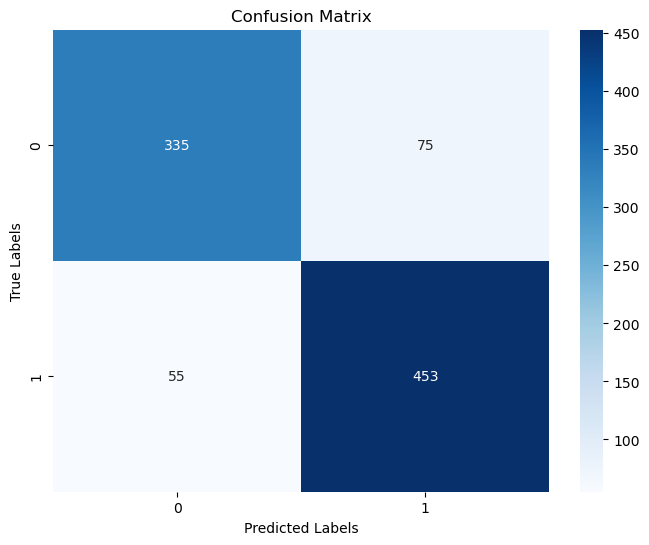

Model: GBC, Accuracy: 0.846, F2 Score: 0.861


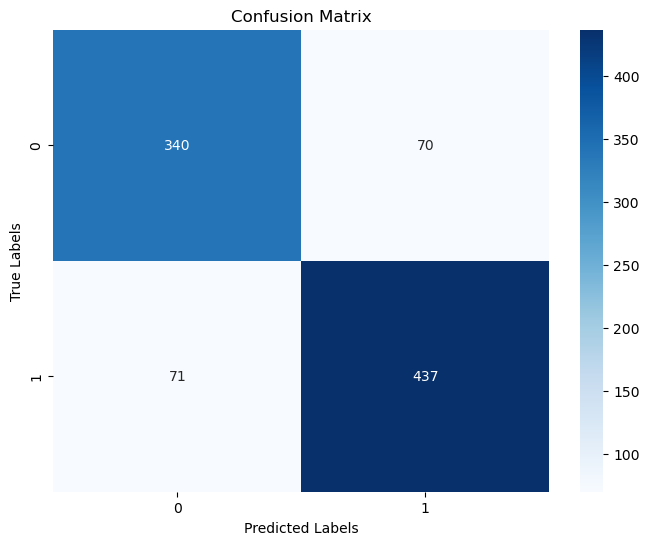

Model: SVC, Accuracy: 0.868, F2 Score: 0.895


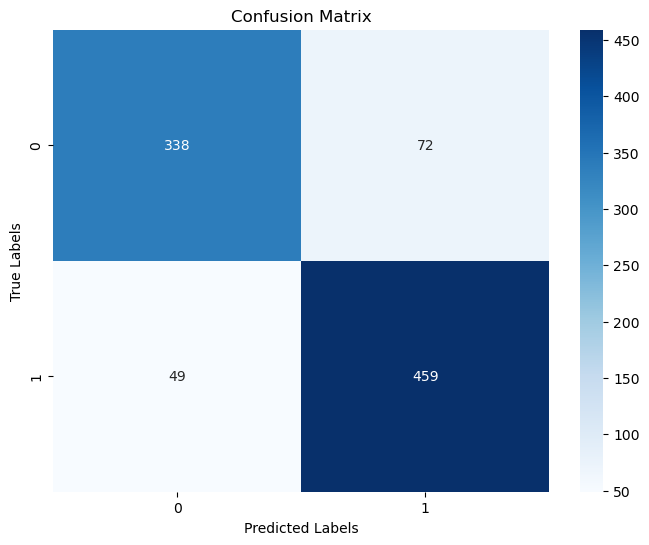

Model: LR, Accuracy: 0.832, F2 Score: 0.851


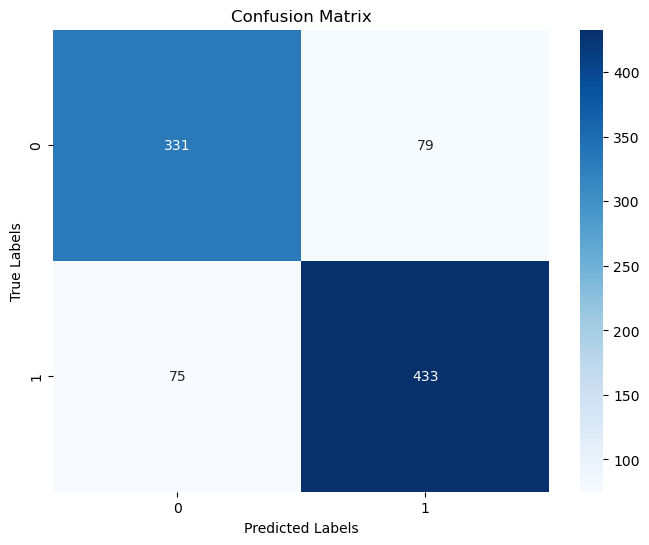

  Model  Accuracy  F1 Score
0   RFC  0.858388  0.884766
1   GBC  0.846405  0.860575
2   SVC  0.868192  0.895435
3    LR  0.832244  0.851022


In [62]:
from sklearn.calibration import cross_val_predict

def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)
# define models to test
def get_models():
  models, names = list(), list()
  # RFC
  models.append(RandomForestClassifier())
  names.append('RFC')
  # GBC
  models.append(GradientBoostingClassifier())
  names.append('GBC')
  # SVC
  models.append(SVC())
  names.append('SVC')
  return models, names

models, names = get_models()
model_performance = []
for i in range(len(models)):
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('power_transformer', PowerTransformer()), 
        ('model', models[i])
    ])
    
    y_pred = cross_val_predict(pipeline, X, y, cv=10) 

    # Compute the desired metrics
    accuracy = accuracy_score(y, y_pred)
    f2 = f2_measure(y, y_pred)

    model_performance.append({
        "Model": names[i],
        "Accuracy": accuracy,
        "F1 Score": f2
    })

    print(f"Model: {names[i]}, Accuracy: {accuracy:.3f}, F2 Score: {f2:.3f}")
    
    # Generate the confusion matrix
    conf_mat = confusion_matrix(y, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Convert the model_performance to a DataFrame for easier analysis
performance_df = pd.DataFrame(model_performance)
print(performance_df)

# Conclusion

### SVC has the highest F2 score and the lowest amount of false negatives, in this case we will go with this model as our best indicator for predicting heart disease